In [119]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 03
### Team Member Names: Sherry, Kelly, Ifan
### Team Strategy Chosen: SAFE

In [120]:
max_stocks = 25 #The total number of stocks we can possibly have
tickers_df = pd.read_csv('Tickers_Example.csv')
#When the CSV file is read, it takes the first ticker and makes it the name of the column, so we need to extract it
tickers_list = list(tickers_df.columns)
#Now add the rest of the tickers in after it:
tickers_list += tickers_df.iloc[:, 0].tolist()
tickers_num = len(tickers_list)

#Dates to pull closing data from, change as needed
start_date = '2020-01-01'
end_date = '2022-11-25'

# Dictionary of all the stocks
stocks_dict = {}
stocks_full_info = {}

# Function produces the daily closing prices of a stock
def get_closing_prices(ticker, start, end):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start, end=end) #Daily
    return hist.Close

for i in range (tickers_num):
    stocks_dict[tickers_list[i]] = get_closing_prices(tickers_list[i], start_date, end_date)
    stocks_full_info[tickers_list[i]] = yf.Ticker(tickers_list[i])

# Create DataFrame
all_prices = pd.DataFrame(stocks_dict)

tickers_list_temp = tickers_list.copy()
#Some tickers are delisted, so we drop those columns entirely
for i in range (tickers_num):
    if all_prices[tickers_list[i]].isnull().all():
        all_prices.drop(columns=[tickers_list[i]], inplace=True)
        tickers_list_temp.remove(tickers_list[i]) #Getting rid of the tickers from our list too to match
        stocks_full_info.pop(tickers_list[i]) #Do the same to the dictionary of yfinance ticker objects

tickers_list = tickers_list_temp.copy()
tickers_num = len(tickers_list)

#Drop the rows at the bottom of the DataFrame where only a few stocks have values and where the dates are strange
all_prices = all_prices.dropna() 

print(tickers_list)

#Display the entire DataFrame, so that we can manually check to make sure the values are sensible
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(all_prices)

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RY.TO', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TD.TO', 'TGT', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,BK,BLK,BMY,C,CAT,CL,CMCSA,COF,COP,COST,CSCO,CVS,GM,GOOG,JPM,KMI,KO,LLY,LMT,MO,MON,MRK,MS,MSFT,NEE,NKE,ORCL,OXY,PEP,PFE,PG,PM,PYPL,QCOM,RY.TO,SBUX,SLB,SO,SPG,T,TD.TO,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-16 00:00:00,124.265907,102.991295,114.960411,257.676697,45.678764,154.593002,140.325378,255.210007,36.480057,259.920013,43.974262,698.315857,58.655907,68.990311,217.884506,72.816872,55.796642,124.143265,52.917683,323.250366,47.165890,72.076767,56.989883,104.625999,146.212936,14.289574,48.974052,186.289169,332.890930,43.404179,9.785,69.581032,78.276802,234.083542,72.760925,142.769958,64.960358,27.963648,128.622879,33.759586,123.469925,80.504601,249.309998,129.892349,108.809341,107.442192,27.394434,57.139629,107.247581,19.613205,76.842155,174.705948,169.330246,347.556335,205.282028,155.261261,50.686962
2021-03-17 00:00:00,123.464317,97.601990,114.376953,258.410065,46.006889,156.786499,141.676697,263.589996,36.780502,264.149994,44.231030,703.289429,58.921234,69.244331,224.783005,72.759277,55.277508,127.196358,53.151505,325.166656,46.928493,71.059029,59.913212,104.554001,147.717865,14.558847,48.993176,182.219910,336.621368,43.702667,9.680,70.024918,79.528618,233.423767,70.425003,142.937775,64.348160,28.827280,128.248566,33.721897,122.971985,81.417343,251.470001,130.154770,109.203346,106.593002,27.638506,56.626530,108.208504,19.717846,76.935699,172.951233,171.442841,345.184418,205.863846,153.191956,51.298893
2021-03-18 00:00:00,119.278244,96.421921,114.853439,260.971985,46.151661,151.399506,139.620300,256.059998,37.739998,262.269989,44.411720,698.953247,59.063370,69.470116,221.944687,73.018456,53.710514,123.969360,49.924820,319.032501,46.339752,71.510292,59.134987,101.810997,150.156174,14.145960,48.352554,179.487518,343.746613,44.396221,9.770,69.997749,79.604492,227.200195,68.658585,141.309219,64.853470,26.425003,127.202370,33.703053,123.240112,82.658691,238.410004,126.102028,109.794334,103.852432,26.603647,56.346672,106.908966,19.626287,77.655930,174.124268,166.672821,354.858368,208.831055,152.762878,52.974651
2021-03-19 00:00:00,118.743851,96.096703,116.934441,257.930908,45.196205,153.748001,137.789139,255.820007,37.342628,267.070007,44.078869,704.660828,59.413982,68.689247,216.758820,71.972168,53.316357,122.152954,49.195301,324.890015,46.510674,70.262123,59.683735,102.160004,147.765472,14.289574,48.582031,179.838837,340.505219,44.378666,9.750,70.215149,78.656143,226.835831,68.378662,135.703018,64.387047,27.894163,129.093216,33.476913,122.579369,82.556931,241.279999,127.336327,109.325287,102.617241,26.408388,55.693634,106.790001,19.462788,77.094704,181.821793,168.221405,358.318268,204.409302,151.895111,51.976730
2021-03-22 00:00:00,122.108543,98.401108,118.120804,259.319427,44.617138,155.543503,137.044891,251.229996,36.499443,272.339996,42.994728,705.897095,60.058342,67.701393,217.461197,72.730492,54.191189,120.983879,48.858604,330.401825,47.764130,70.540565,57.967651,101.929497,143.793701,14.163912,48.763695,181.351410,342.989044,45.335594,9.700,70.215149,77.688820,232.389786,69.199135,136.472885,64.445343,27.258850,132.260529,33.919762,124.657318,83.232201,244.384995,130.320007,108.799965,103.804184,26.994162,55.684311,105.472176,19.613205,76.832802,182.296783,172.159790,359.572845,200.016647,153.582932,51.063538
2021-03-23 00:00:00,121.267387,97.416153,117.167816,260.130981,43.410744,156.875000,133.255234,241.250000,35.762867,267.209991,42.195892,692.038330,59.338177,66.713539,209.985413,74.631058,53.970078,118.268944,48.362907,336.180359,47.488750,69.033165,56.032074,102.648003,142.355484,14.074154,49.136597,179.243561,339.105103,44.343544,9.660,69.091858,75.033440,233.955536,71.448174,135.337860,65.368477,26.395222,133.853806,33.316742,126.974655,81.446930,243.770004,128.794144,108.668625,102.530388,26.037405,56.561230,101.042801,19.619747,76.439934,183.149918,170.897964,361.180237,201.742676,152.438660,50.442184
2021-03-24 00:

In [121]:
## doesnt work yet 
# Remove invalid stocks per assignment requirement (ones outside of the U.S & ones with average monthly volume of less than 200,000 shares)

def filter_market(df):
    df_transposed = df.T
    for i in range(len(df_transposed)):
        # Add country of market as a column to dataframe
        df_transposed["Market"].iloc[i] = stocks_full_info[i].info['market']
    
    # Drops the stocks in markets that are not in the U.S
    df_transposed.drop(df_transposed[df_transposed.Market != "us_market"].index, inplace=True)
    df_transposed = df_transposed.drop('Market', axis=1)
    return_df = df.T

    return return_df


def filter_volume(df):

    start = "2022-01-01"
    end = "2022-10-31"

    df_transposed = df.T

    for i in range(len(df_transposed)):
        ticker = yf.Ticker(df_transposed.iloc[i])
        ticker_hist = ticker.history(start=start, end=end)

        volume_hist = ticker_hist.loc[(ticker_hist.index >= pd.to_datetime(start)) & (ticker_hist.index <= pd.to_datetime(end))]
        df_transposed["Volume"].iloc[i] = (volume_hist.info['averageDailyVolume10Day'].mean())*3

    # Drops the stocks with volumes less than average monthly volume of 200,000
    df_transposed.drop(df_transposed[df_transposed.Volume < 200000].index, inplace=True)
    df_transposed = df_transposed.drop('Volume', axis=1)
    return_df = df.T

    return return_df

all_prices = all_prices.loc[filter_market(all_prices)]
all_prices = all_prices.loc[filter_volume(all_prices)]

# Drops stocks with more than specified number of NaN values
max_number_of_nans = 20
all_prices = all_prices.loc[:, (all_prices.isnull().sum(axis=0) <= max_number_of_nans)]


KeyError: 0

In [123]:
#Function to get the beta of a stock against a given market
def stock_beta(stock_ticker, market_index):
    
    #Get basic info on both the stock and the market
    index_ticker = yf.Ticker(market_index)
    stock_ticker_object = yf.Ticker(stock_ticker)
    stock_hist = stock_ticker_object.history(start=start_date, end=end_date)
    MarketIndex_hist = index_ticker.history(start=start_date, end=end_date)
    
    #Get the closing prices of both the stock and market
    prices = pd.DataFrame(stock_hist['Close'])
    prices.columns = [stock_ticker]
    prices[market_index] = MarketIndex_hist['Close']
    
    #Daily returns of both stock and market
    daily_returns = prices.pct_change()
    daily_returns.drop(index=daily_returns.index[0], inplace=True) #Drop the first entry since it's NaN
    
    #Calculate market variance
    MarketVar = daily_returns[market_index].var()
    
    #Now calculate the beta by taking the covariance
    beta = daily_returns.cov() / MarketVar
    
    return beta.iat[0,1] #To get the value we need, don't care about the others

In [124]:
daily_returns = all_prices.pct_change()

#New DataFrame to hold our std and beta stats
stats_df = pd.DataFrame(daily_returns.std())
stats_df.columns = ['std']

# Calculate BETA against S&P500
MarketIndex = '^GSPC' #This is the symbol yfinance uses for the S&P 500
beta_list = []

for i in range (tickers_num):
    beta_list.append(stock_beta(tickers_list[i], MarketIndex))

stats_df['beta'] = beta_list
stats_df

,std,beta
AAPL,0.019201,1.188618
ABBV,0.013670,0.596186
ABT,0.015422,0.817143
ACN,0.017388,1.089168
AIG,0.019924,1.321105
AMZN,0.026085,0.991961
AXP,0.020687,1.347074
BA,0.026140,1.551863
BAC,0.018736,1.230844
BIIB,0.033640,0.835479


In [125]:
#Get a pandas series of the beta and sd, sorted in ascending order, then put that in a DataFrame
beta_df = pd.DataFrame(stats_df['beta'].sort_values(ascending=True))
std_df = pd.DataFrame(stats_df['std'].sort_values(ascending=True))

#Now we give each stock points in each category using a list
std_points = []
beta_points = []
for i in range (tickers_num):
    std_points.append(tickers_num - i) #So the stocks with the lowest std get the highest number of points
    beta_points.append(tickers_num - i) #So the stocks with the lowest beta get the highest number of points

#Add our lists to our DataFrames as new columns
beta_df['points'] = beta_points
std_df['points'] = std_points

#Store all the necessary points values we need, adding the points from beta and std together
total_points = pd.DataFrame(std_df['points'])
total_points.columns = ['std']
total_points['beta'] = pd.DataFrame(beta_df['points'])
total_points['total'] = total_points['std'] + total_points['beta']

#Now we isolate the total points and sort that series from highest to lowest before turning it back into a DataFrame
#Since we want to prioritize the stocks with the highest number of total points
final_points = pd.DataFrame(total_points['total'].sort_values(ascending=False))
final_points.reset_index(inplace=True)
final_points.columns = ['tickers', 'points']
final_points

,tickers,points
0,MON,114
1,BMY,107
2,CL,106
3,KO,101
4,PG,100
5,MRK,100
6,RY.TO,100
7,ABBV,100
8,TD.TO,95
9,PEP,94


In [126]:
selected_tickers = []
sector_count = {}
sector_max = 5

for i in range (tickers_num):
    #We only want choose the maximum number of stocks we can (initiated in the very beginning of the code), not the
    # total number of stocks we have, so if we have enough stocks, do nothing
    if len(selected_tickers) < max_stocks: 
        temp = stocks_full_info[tickers_list[i]]
        sector = temp.info['sector']
        if sector in sector_count: #If there is a key in sector_count that matches the sector of our stock
            #If our current number of stocks is less than our maximum, then we add it, otherwise we just skip over it
            # and do nothing
            if sector_count[sector] < sector_max: 
                selected_tickers.append(final_points.tickers[i])
                sector_count[sector] += 1
        else: #So if there is no sector in our dictionary that matches that of the stock
            selected_tickers.append(final_points.tickers[i])
            sector_count[sector] = 1

#Takes maybe up to 10 minutes to load the first time around, yfinance is very slow
selected_tickers

['MON',
 'BMY',
 'CL',
 'KO',
 'PG',
 'MRK',
 'RY.TO',
 'ABBV',
 'TD.TO',
 'PEP',
 'MO',
 'PM',
 'LMT',
 'T',
 'CVS',
 'PFE',
 'ABT',
 'LLY',
 'UNP',
 'UNH',
 'NEE',
 'CMCSA',
 'KMI',
 'UPS',
 'BK']

In [127]:
sector_count

{'Technology': 3,
 'Healthcare': 5,
 'Financial Services': 5,
 'Consumer Cyclical': 2,
 'Industrials': 3,
 'Consumer Defensive': 3,
 'Communication Services': 2,
 'Energy': 2}

In [135]:
selected_ticker_prices = pd.DataFrame()
selected_portfolio = pd.DataFrame()
selected_ticker_returns = pd.DataFrame()
selected_ticker_points = []
selected_ticker_weights = []
shares_per_stock = []
investment = 500000 #500,000

#Get the number of points associated with each of our chosen tickers
for i in range (len(selected_tickers)):
    selected_ticker_points.append(total_points.total[selected_tickers[i]])

#Calculate the weighting that should be given to each of our selected tickers, based on how their points compare to 
# that of the other chosen stocks
for i in range (len(selected_tickers)):
    selected_ticker_weights.append(selected_ticker_points[i] / sum(selected_ticker_points))
    selected_ticker_prices[selected_tickers[i]] = all_prices[selected_tickers[i]]
    selected_ticker_returns[selected_tickers[i]] = daily_returns[selected_tickers[i]]
    shares_per_stock.append((investment * selected_ticker_weights[i]) / selected_ticker_prices.iloc[0, i])
    selected_portfolio[selected_tickers[i]] = shares_per_stock[i] * selected_ticker_prices[selected_tickers[i]]

selected_portfolio['total'] = selected_portfolio.sum('columns')
selected_ticker_prices


,MON,BMY,CL,KO,PG,MRK,RY.TO,ABBV,TD.TO,PEP,...,PFE,ABT,LLY,UNP,UNH,NEE,CMCSA,KMI,UPS,BK
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,9.785,58.655907,72.816872,48.974052,123.469925,69.581032,108.809341,102.991295,76.842155,128.622879,...,33.759586,114.960411,186.289169,205.282028,347.556335,72.760925,55.796642,14.289574,155.261261,43.974262
2021-03-17,9.680,58.921234,72.759277,48.993176,122.971985,70.024918,109.203346,97.601990,76.935699,128.248566,...,33.721897,114.376953,182.219910,205.863846,345.184418,70.425003,55.277508,14.558847,153.191956,44.231030
2021-03-18,9.770,59.063370,73.018456,48.352554,123.240112,69.997749,109.794334,96.421921,77.655930,127.202370,...,33.703053,114.853439,179.487518,208.831055,354.858368,68.658585,53.710514,14.145960,152.762878,44.411720
2021-03-19,9.750,59.413982,71.972168,48.582031,122.579369,70.215149,109.325287,96.096703,77.094704,129.093216,...,33.476913,116.934441,179.838837,204.409302,358.318268,68.378662,53.316357,14.289574,151.895111,44.078869
2021-03-22,9.700,60.058342,72.730492,48.763695,124.657318,70.215149,108.799965,98.401108,76.832802,132.260529,...,33.919762,118.120804,181.351410,200.016647,359.572845,69.199135,54.191189,14.163912,153.582932,42.994728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,9.995,77.160004,75.290001,60.709999,140.869995,102.309998,132.320007,152.160004,88.730003,180.029999,...,48.330002,102.559998,360.769989,209.820007,515.309998,81.933891,34.259998,18.299999,176.059998,43.880001
2022-11-18,9.995,77.449997,76.459999,61.139999,142.570007,104.230003,132.699997,154.979996,89.419998,181.330002,...,48.230000,103.870003,361.670013,210.580002,530.000000,82.779594,34.500000,18.420000,178.970001,44.560001
2022-11-21,9.995,78.959999,76.919998,62.080002,144.380005,105.610001,132.949997,157.110001,89.760002,184.820007,...,48.180000,103.879997,361.170013,212.270004,517.190002,83.177574,34.349998,18.280001,180.610001,44.650002


In [129]:
top_number_of_stocks = 30
top_stocks_returns = pd.DataFrame()
top_stocks_tickers = []

for i in range (top_number_of_stocks):
    top_stocks_tickers.append(final_points['tickers'])
    top_stocks_returns[top_stocks_tickers[i]] = daily_returns[top_stocks_tickers[i]]

top_stocks_returns

,MON,BMY,CL,KO,PG,MRK,RY.TO,ABBV,TD.TO,PEP,...,COP,SLB,AXP,SPG,QCOM,GM,COF,PYPL,BA,OXY
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-17,-0.010731,0.004523,-0.000791,0.000390,-0.004033,0.006379,0.003621,-0.052328,0.001217,-0.002910,...,0.004419,0.008910,0.009630,0.008960,0.002020,0.051296,0.024593,0.008664,0.032836,0.030884
2021-03-18,0.009298,0.002412,0.003562,-0.013076,0.002180,-0.000388,0.005412,-0.012091,0.009361,-0.008158,...,-0.060707,-0.037443,-0.014515,-0.012010,-0.031138,-0.012989,-0.025370,-0.051935,-0.028567,-0.083333
2021-03-19,-0.002047,0.005936,-0.014329,0.004746,-0.005361,0.003106,-0.004272,-0.003373,-0.007227,0.014865,...,-0.014612,-0.007340,-0.013115,-0.001113,0.009788,0.009280,-0.014652,0.012038,-0.000937,0.055597
2021-03-22,-0.005128,0.010845,0.010536,0.003739,0.016952,0.000000,-0.004805,0.023980,-0.003397,0.024535,...,-0.006844,0.022181,-0.005401,-0.012340,0.023431,-0.028753,-0.009571,0.012869,-0.017942,-0.022776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,0.000000,0.013263,-0.009472,0.003139,-0.006138,0.023817,0.006083,0.001910,0.006808,0.009533,...,0.015088,-0.003019,-0.012650,0.001730,0.017643,0.004419,-0.022799,-0.016085,0.000521,-0.006534
2022-11-18,0.000000,0.003758,0.015540,0.007083,0.012068,0.018767,0.002872,0.018533,0.007776,0.007221,...,-0.019819,0.011546,0.012347,0.018223,0.008058,0.029244,-0.004827,-0.008407,0.006424,-0.002939
2022-11-21,0.000000,0.019496,0.006016,0.015375,0.012696,0.013240,0.001884,0.013744,0.003802,0.019247,...,-0.024108,-0.021894,0.002033,-0.006107,-0.029471,-0.006286,0.023747,-0.050518,-0.005463,-0.023298


In [140]:
#returns the redundant pairs in the matrix, such as AAPL and AAPL or AAPL and ABBV with AABV and AAPL
def get_redundant_pairs(df):
    to_drop = set()
    cols = df.columns

    #itereate through the rows and the columns to drop any redundant pairs
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            to_drop.add((cols[i], cols[j]))

    return to_drop

def get_neg_correlations(df):
    #unstack to make it easier to read, outputting a series 
    sorted_corr = df.corr().unstack()
    #dropping the redundant pairs 
    to_drop = get_redundant_pairs(df)
    sorted_corr = sorted_corr.drop(labels=to_drop).sort_values(ascending=True)
    return sorted_corr

print("\nNegative Correlations")
get_neg_correlations(selected_ticker_returns)


Negative Correlations


MON  PM      -0.029213
     TD.TO   -0.014073
     T       -0.011698
     NEE     -0.009067
     BMY     -0.002335
                ...   
CL   KO       0.708749
     PEP      0.709080
PG   PEP      0.734509
CL   PG       0.751743
KO   PEP      0.810738
Length: 300, dtype: float64

In [158]:
temp = pd.DataFrame(get_neg_correlations(top_stocks_returns))
neg_corr = temp.reset_index()
neg_corr.rename(columns = {'level_0':'Ticker 1', 'level_1':'Ticker 2'}, inplace = True)
display(neg_corr)

#Function to remove any instances of a ticker from a DataFrame set up like neg_corr
def remove_instances(ticker, df):
    #Loop through all rows of the DataFrame
    new_df = df.copy()
    index_to_drop = []
    for i in range (len(df.index)):
        if ticker == new_df['Ticker 1'][i]:
            index_to_drop.append(i)
        elif ticker == new_df['Ticker 2'][i]:
            index_to_drop.append(i)
        
    new_df.drop(labels=index_to_drop, inplace=True)
    return new_df



,Ticker 1,Ticker 2,0
0,MON,USB,-0.048533
1,PG,OXY,-0.038462
2,CL,OXY,-0.037096
3,MON,COF,-0.032546
4,MON,PM,-0.029213
...,...,...,...
1591,KO,PEP,0.810738
1592,MSFT,GOOG,0.814204
1593,JPM,C,0.818661
1594,BAC,C,0.830907


,Ticker 1,Ticker 2,0
0,MON,USB,-0.048533
3,MON,COF,-0.032546
4,MON,PM,-0.029213
5,MON,AXP,-0.019170
7,MON,COP,-0.016257
...,...,...,...
1591,KO,PEP,0.810738
1592,MSFT,GOOG,0.814204
1593,JPM,C,0.818661
1594,BAC,C,0.830907


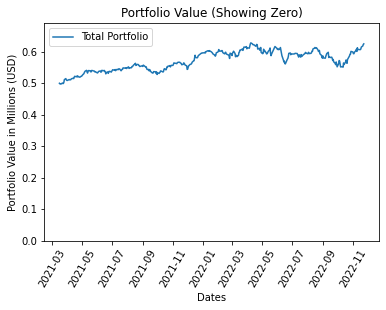

In [133]:
#Because otherwise the graph will automatically be in scientific notation, which is not 
interval = ['Millions', 1000000] #First element is the name, second element is the number

#Graph the selected portfolio value
plt.plot(selected_portfolio.index, selected_portfolio['total'] / interval[1], label='Total Portfolio')

plt.title('Portfolio Value (Showing Zero)')
plt.xlabel('Dates')
plt.xticks(rotation=60)
plt.ylabel('Portfolio Value in ' + interval[0] + ' (USD)')
#Show zero so that we can get a more accurate idea of how much the portfolio value changed overall, in the grand 
# scheme of things
plt.ylim([0, max(selected_portfolio['total'] / interval[1]) + 0.1 * max(selected_portfolio['total'] / interval[1])])
plt.legend(loc='best')

plt.show()

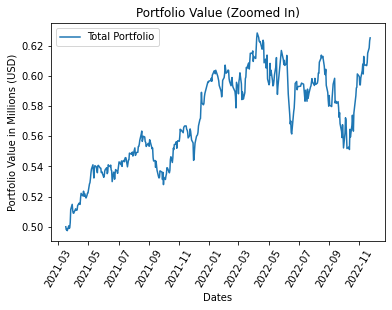

In [134]:
#Graph the selected portfolio value
plt.plot(selected_portfolio.index, selected_portfolio['total'] / interval[1], label='Total Portfolio')

plt.title('Portfolio Value (Zoomed In)')
plt.xlabel('Dates')
plt.xticks(rotation=60)
plt.ylabel('Portfolio Value in ' + interval[0] + ' (USD)')
plt.legend(loc='best')

plt.show()

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.